In [ ]:
%load_ext autoreload
%autoreload 2
import os

while not os.getcwd().endswith("naml_exams"):
    os.chdir("..")

# Exercise 1


In [ ]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import os

plt.rcParams["figure.figsize"] = [16, 8]

Load the image of the Karman vortices with the following commands


In [ ]:
A = imread("data/Karman_vortex.jpg")
X = np.mean(A, -1);  # Convert RGB to grayscale

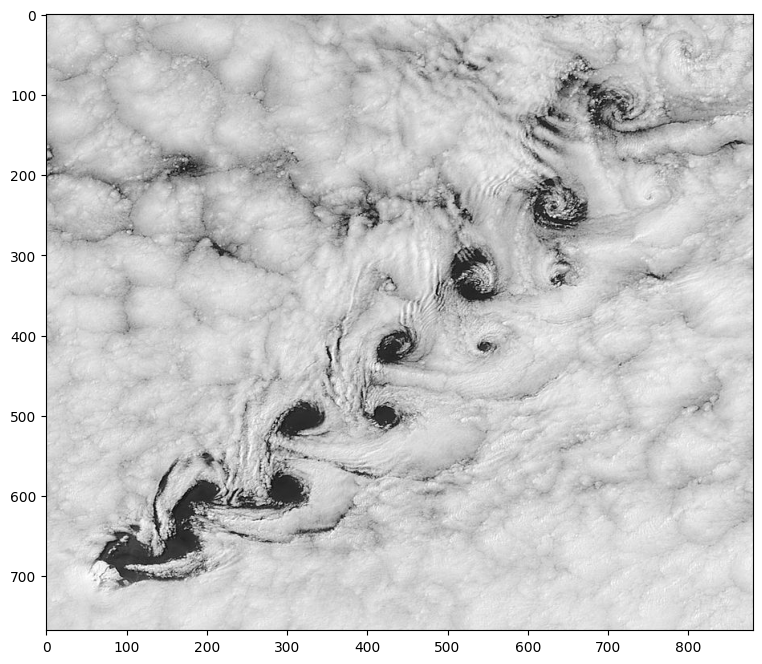

In [ ]:
img = plt.imshow(X)
img.set_cmap("gray")
plt.show()

Compute the economy SVD.


In [ ]:
U, s, VT = np.linalg.svd(X, full_matrices=False)
U.shape, s.shape, VT.shape

((768, 768), (768,), (768, 881))

Let $\mathbf{X}$ be the matrix representing the true image and $\tilde{\mathbf{X}}$ the approximation of rank $r$ obtained using the SVD. Compute and plot the relative reconstruction error of the truncated SVD in the Frobenius norm as a function of the rank r. The expression of the relative reconstruction error is given by:

$$
\frac{\lVert \mathbf{X} - \tilde{\mathbf{X}} \rVert_F}{\lVert \mathbf{X} \rVert_F}
$$


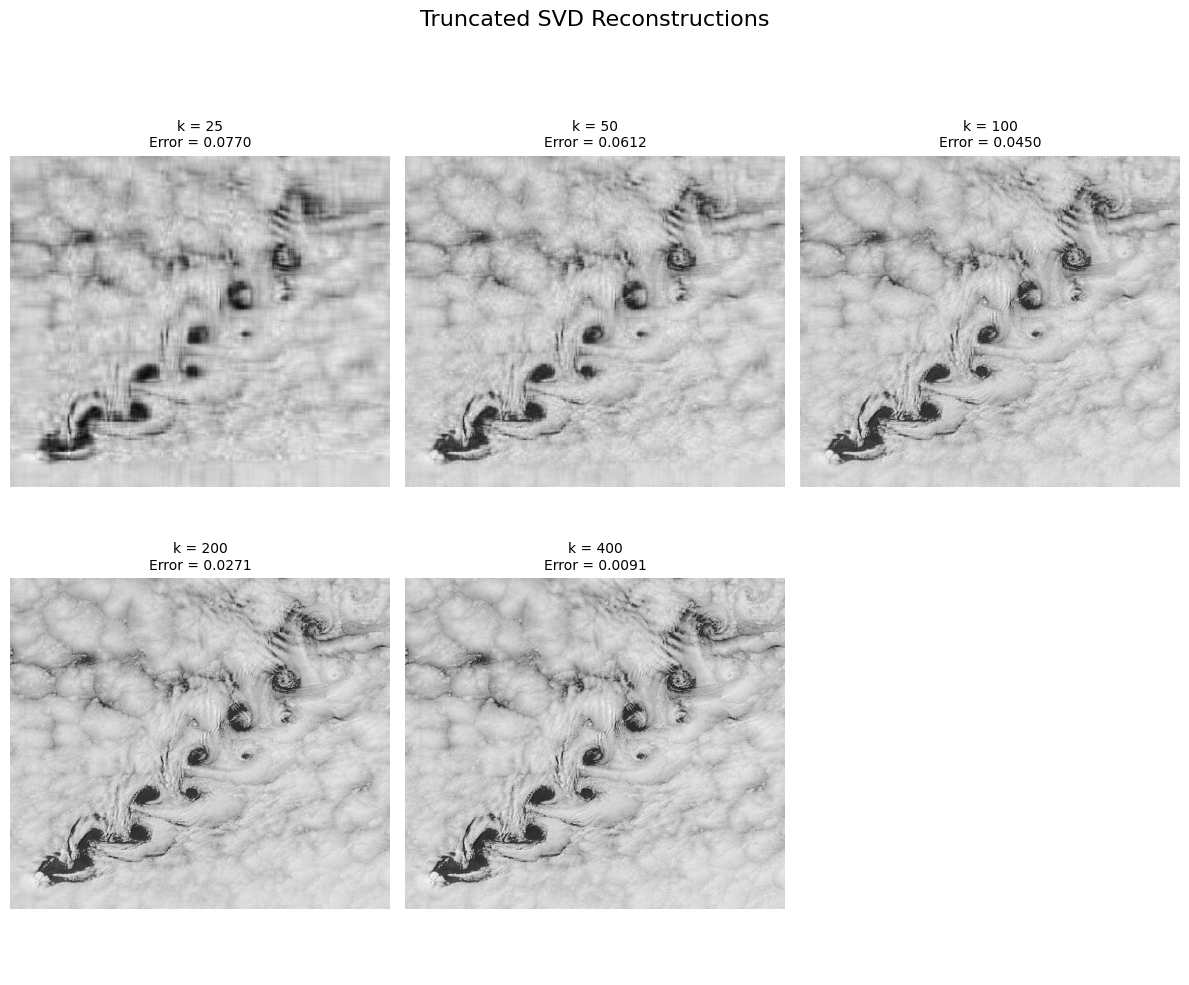

In [ ]:
ks = [25, 50, 100, 200, 400]
recon_error = []

# Perform SVD once
U, s, VT = np.linalg.svd(X, full_matrices=False)

# Create 3x2 subplot grid
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
axs = axs.flatten()  # Flatten to access via a single index

for i, k in enumerate(ks):
    # Truncate SVD to rank-k
    Xk = U[:, :k] @ np.diag(s[:k]) @ VT[:k, :]

    # Compute reconstruction error
    error = np.linalg.norm(X - Xk, ord="fro") / np.linalg.norm(X, ord="fro")
    recon_error.append(error)

    # Plot image
    axs[i].imshow(Xk, cmap="gray")
    axs[i].set_title(f"k = {k}\nError = {error:.4f}", fontsize=10)
    axs[i].axis("off")

# Turn off any unused subplot (like the 6th one in this case)
for j in range(len(ks), len(axs)):
    axs[j].axis("off")

# Add a main title and layout adjustments
fig.suptitle("Truncated SVD Reconstructions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

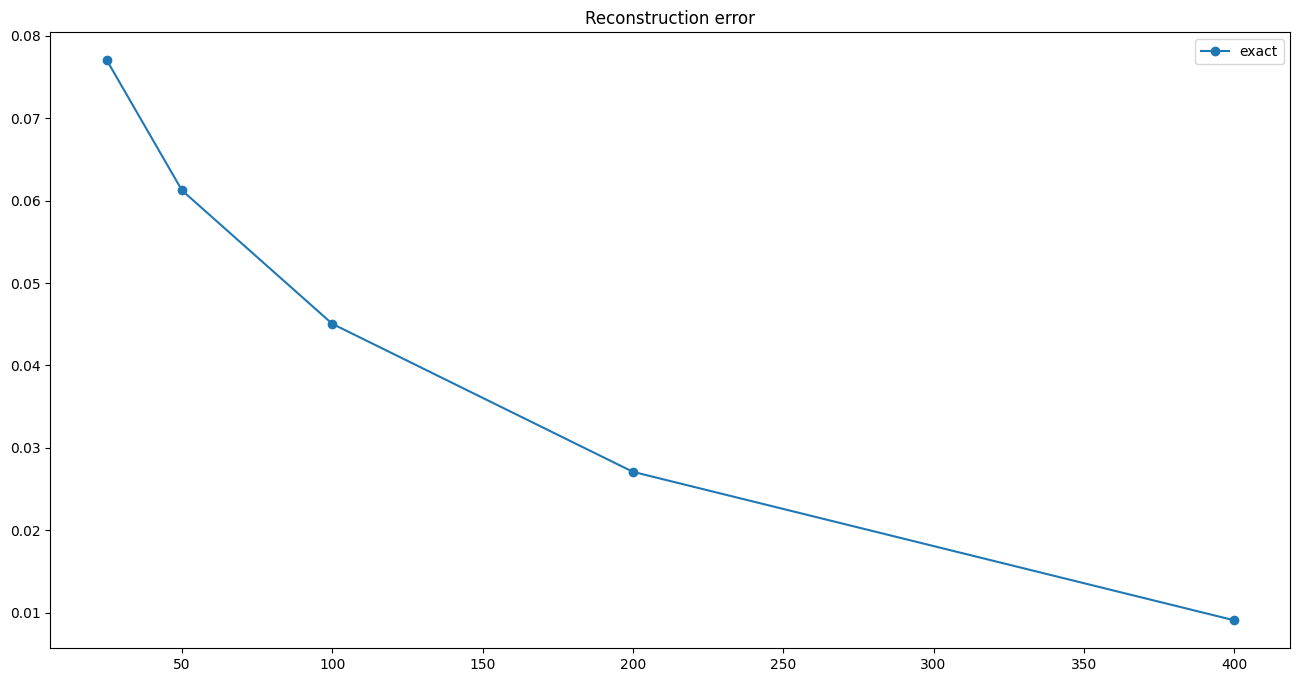

In [ ]:
plt.plot(ks, recon_error, "o-")
plt.title("Reconstruction error")

Square this error (and plot it) to compute the fraction of the missing variance as a function of r.


Text(0.5, 1.0, 'Sqaured reconstruction error')

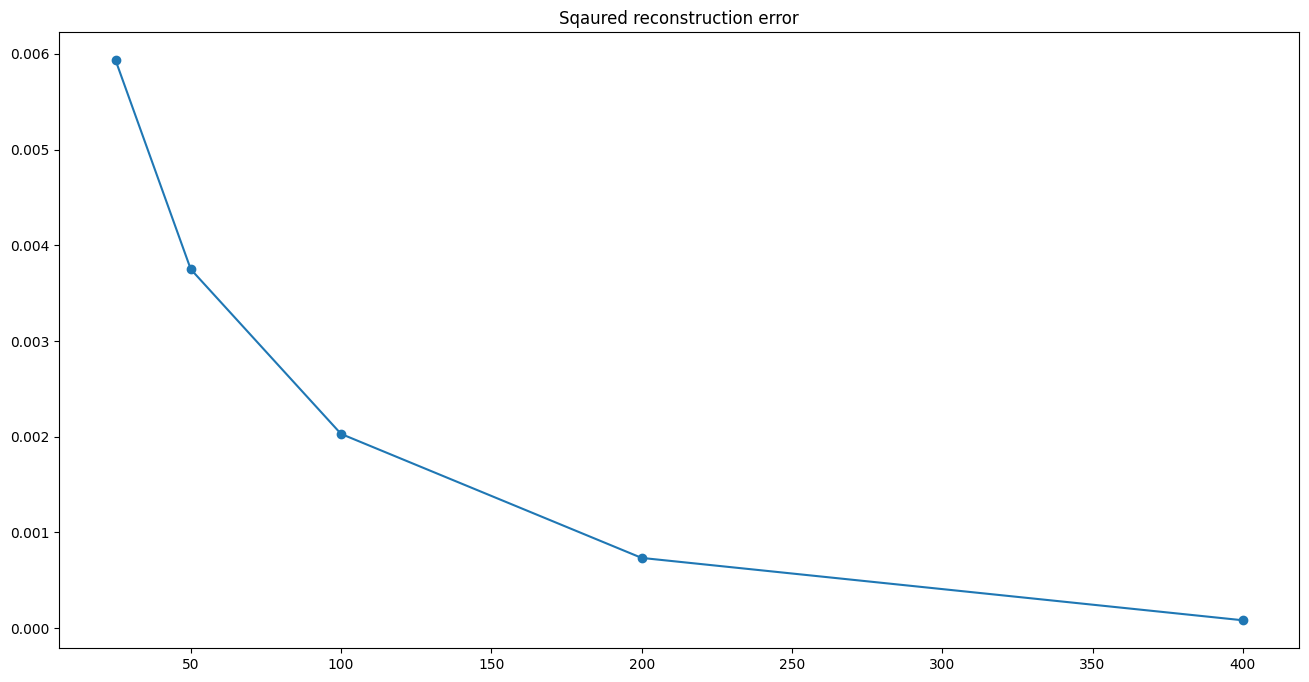

In [ ]:
squared_recon_error = np.array(recon_error) ** 2
plt.plot(ks, squared_recon_error, "o-")
plt.title("Sqaured reconstruction error")

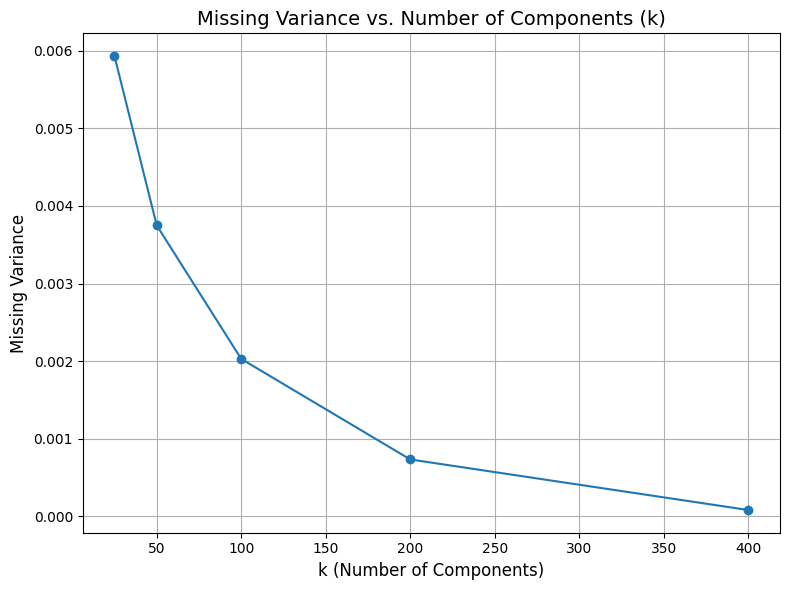

In [ ]:
ks = [25, 50, 100, 200, 400]
missing_variance = []

# Compute SVD once
U, s, VT = np.linalg.svd(X, full_matrices=False)
total_variance = np.sum(s**2)

# Compute missing variance for each k
for k in ks:
    retained_variance = np.sum(s[:k] ** 2)
    missing = 1 - (retained_variance / total_variance)
    missing_variance.append(missing)

# Plot missing variance vs k
plt.figure(figsize=(8, 6))
plt.plot(ks, missing_variance, marker="o")
plt.title("Missing Variance vs. Number of Components (k)", fontsize=14)
plt.xlabel("k (Number of Components)", fontsize=12)
plt.ylabel("Missing Variance", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Find the rank $\tilde{r}$ for which the reconstruction captures 99% of the total variance.


In [ ]:
# Perform SVD
U, s, VT = np.linalg.svd(X, full_matrices=False)

# Compute cumulative explained variance ratio
explained_variance_ratio = np.cumsum(s**2) / np.sum(s**2)

# Find the smallest rank that captures at least 99% variance
r_tilde = (
    np.argmax(explained_variance_ratio >= 0.99) + 1
)  # +1 because index starts at 0

print(f"The minimum rank r̃ that captures 99% of the total variance is: {r_tilde}")

The minimum rank r̃ that captures 99% of the total variance is: 11


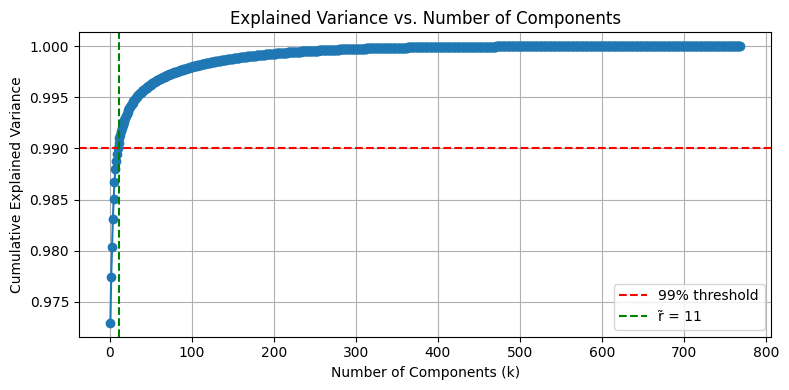

In [26]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(s)+1), explained_variance_ratio, marker='o')
plt.axhline(y=0.99, color='r', linestyle='--', label='99% threshold')
plt.axvline(x=r_tilde, color='g', linestyle='--', label=f'r̃ = {r_tilde}')
plt.xlabel("Number of Components (k)")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Exercise 2

In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

np.random.seed(42)

Generate 100 artificial data points $(x_i,y_i)$ where $x_i$ is randomly generated in the interval $[0,1]$ and $y_i = cos(4πx_i)+ϵ$; $ϵ$ is a random noise in the interval $[−0.2,0.2]$.

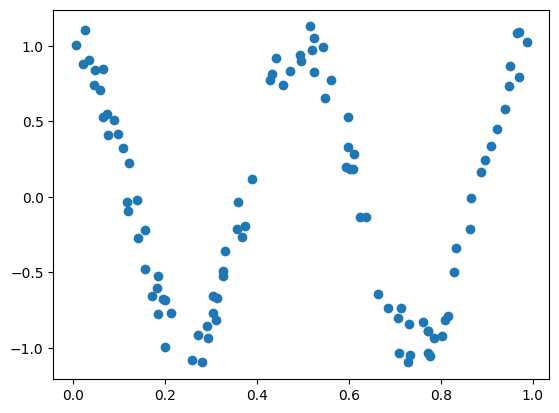

In [2]:
x = np.random.uniform(0, 1, 100)
eps = np.random.uniform(-0.2, 0.2, 100)
y = np.cos(4*np.pi*x) + eps

plt.scatter(x, y)

Implement the SGD method to solve the regression problem for the data you have generated. 

Use an initial constant learning rate $\eta = 0.001$ and train a polynomial of the form $h_c = c_0 +c_1x+c_2x_2 +...+c_nx_n$ using your data ($n$ is the maximum degree of the polynomial). 

Assume that all the initial parameters $c_i$ are randomly generated in $[−0.4,0.4]$.

In [36]:
# ---- Polynomial Evaluation ----
def evaluate_polynomial(x, params):
    powers = jnp.array([x**i for i in range(len(params))])  # shape: (n+1, batch_size)
    return jnp.dot(params, powers)  # returns (batch_size,)

# ---- Loss Function (MSE) ----
def loss(x, y, params):
    y_pred = evaluate_polynomial(x, params)
    return jnp.mean((y - y_pred)**2)

# ---- Parameter Initialization in [-0.4, 0.4] ----
def initialize_params(n):
    return jnp.array(np.random.uniform(low=-0.4, high=0.4, size=n+1))

# ---- Stochastic Gradient Descent ----
def SGD(x_train, y_train, degree, learning_rate, num_epochs, batch_size):
    params = initialize_params(degree)
    n_samples = len(x_train)

    grad_fn = jax.jit(jax.grad(loss, argnums=2))
    loss_fn = jax.jit(loss)

    history = [loss_fn(x_train, y_train, params)]

    for epoch in range(num_epochs):
        idxs = np.random.choice(n_samples, batch_size, replace=False)
        x_batch = x_train[idxs]
        y_batch = y_train[idxs]

        grads = grad_fn(x_batch, y_batch, params)
        params = params - learning_rate * grads

        history.append(loss_fn(x_train, y_train, params))

    return params, history

Try different values of $n$.

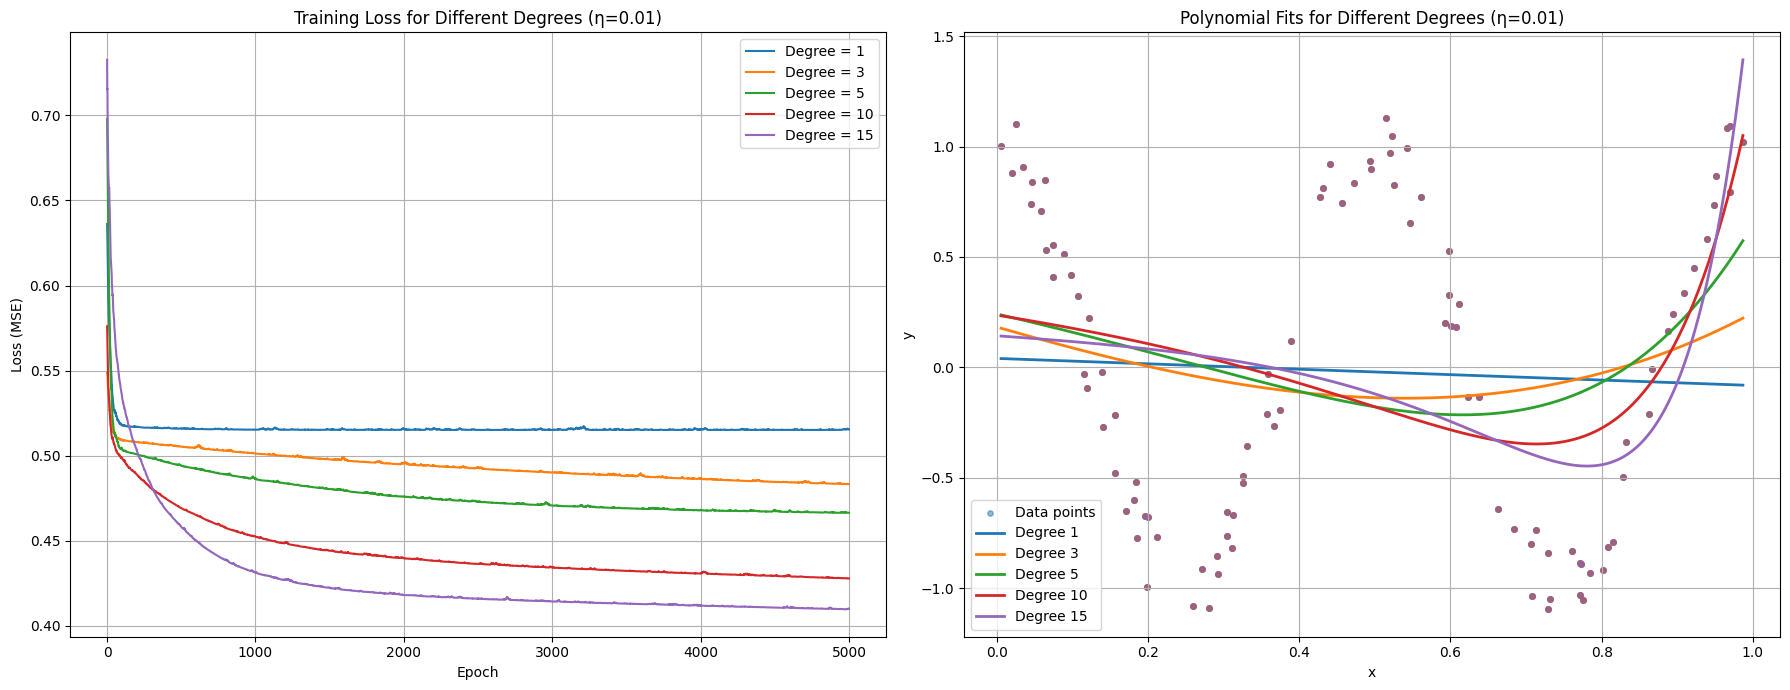

In [37]:
degrees = [1, 3, 5, 10, 15]
eta = 0.01
num_epochs = 5000
batch_size = 32

x_plot = np.linspace(np.min(x), np.max(x), 300)

fig, axs = plt.subplots(1, 2, figsize=(18, 7))

# Left subplot: training loss curves
for deg in degrees:
    params_learned, loss_history = SGD(
        x, y,
        degree=deg,
        learning_rate=eta,
        num_epochs=num_epochs,
        batch_size=batch_size
    )
    axs[0].plot(loss_history, label=f'Degree = {deg}')

axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss (MSE)')
axs[0].set_title(f'Training Loss for Different Degrees (η={eta})')
axs[0].legend()
axs[0].grid(True)

# Right subplot: fitted polynomial curves
for deg in degrees:
    params_learned, _ = SGD(
        x, y,
        degree=deg,
        learning_rate=eta,
        num_epochs=num_epochs,
        batch_size=batch_size
    )
    y_fit = evaluate_polynomial(x_plot, params_learned)
    axs[1].scatter(x, y, s=15, alpha=0.5, label='Data points' if deg == degrees[0] else "")
    axs[1].plot(x_plot, y_fit, label=f'Degree {deg}', linewidth=2)

axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title(f'Polynomial Fits for Different Degrees (η={eta})')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Try also different values for $\eta$ to speed up the learning process. 

Plot the various results and comment them.

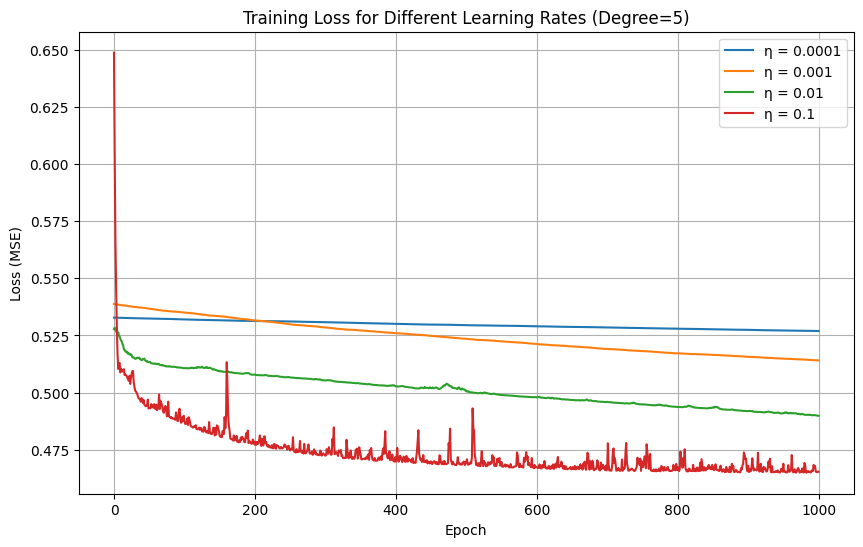

In [28]:
etas = [0.0001, 0.001, 0.01, 0.1]  # Different learning rates
degree = 5
num_epochs = 1000
batch_size = 32

plt.figure(figsize=(10, 6))

for eta in etas:
    params_learned, loss_history = SGD(
        x, y,
        degree=degree,
        learning_rate=eta,
        num_epochs=num_epochs,
        batch_size=batch_size
    )
    plt.plot(loss_history, label=f'η = {eta}')

plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title(f'Training Loss for Different Learning Rates (Degree={degree})')
plt.legend()
plt.grid(True)
plt.show()

Small $\eta$ (e.g., 0.0001): Slow but steady decrease in loss.

Moderate $\eta$ (e.g., 0.001, 0.01): Faster convergence, smooth curves.

Large $\eta$ (e.g., 0.1): Possibly unstable, loss might oscillate or even diverge.

- The degree n of the polynomial does not particularly impact the obtained graph for a relatively small number of iterations. However from the theory we know that if it is too big it may cause overfitting. In particular a order 4 polynomial should already provide a good representation for the data due to it's possibility to have 3 changes of convexity.
- The learning rate proved to be a more impactfull parameter. In particular choosing it too small the convergence became too slow, changing it too big make the convergence faster but induce more variance.
- The best learning rate for a relatively low number of iteration is between 0.1 and 0.01
- The difficulty of the process of finding the best polynomial is due to the fact that the proposed function is perodic which makes the SGD easily proceed in the wrong direction